<a href="https://colab.research.google.com/github/ShumengJ/ECEGY6143-ML-Archive/blob/main/8_hw_fine_tune_food_solution_InceptionResNetV2_s21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning: classifying food items

This is a solution notebook for Summer 2021, using an InceptionResnetV2 base model.


This week, we practiced using transfer learning to classify hand shapes as rock, paper, or scissors.

But that was a relatively easy problem. In this notebook, we'll work on classifying photographs of food items into 11 classes: bread, dairy product, dessert, egg, fried food, meat, noodles/pasta, rice, seafood, soup, and vegetable/fruit.

This is a more challenging problem, because there is a lot of intra-class variability (e.g. different fruits and vegetables don't have a lot in common) and also some inter-class similarity (e.g. a bowl of rice can look similar to a bown of pasta).

To see what we mean by these, let's look at some examples of food photographs from the dataset that we'll work with.



Note: you can refer to this week's demo notebook for a closely related example.

Note: you may want to change the notebook's runtime type to GPU, for faster model training.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shutil
from PIL import Image

import tensorflow as tf

## Get data

We are going to use the [Food-11 dataset](https://www.epfl.ch/labs/mmspg/downloads/food-image-datasets/), from the EPFL Multimedia Signal Processing Group. Here's a description:

> This is a dataset containing 16643 food images grouped in 11 major food categories. The 11 categories are Bread, Dairy product, Dessert, Egg, Fried food, Meat, Noodles/Pasta, Rice, Seafood, Soup, and Vegetable/Fruit. Similar as Food-5K dataset, the whole dataset is divided in three parts: training, validation and evaluation. The same naming convention is used, where ID 0-10 refers to the 11 food categories respectively.
>
> The total file size of the Food-11 dataset is about 1.16 GB.



In [ ]:
classes = np.array(["Bread", "Dairy product", "Dessert", "Egg", "Fried food",
	"Meat", "Noodles/Pasta", "Rice", "Seafood", "Soup",
	"Vegetable/Fruit"])

In [ ]:
%cd /content
!wget https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/food-datasets/Food-11.zip --output-document Food-11.zip

/content
--2021-08-06 02:19:56--  https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/food-datasets/Food-11.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.225.16
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.225.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1163903300 (1.1G) [application/zip]
Saving to: ‘Food-11.zip’

Food-11.zip         100%[===================>]   1.08G  18.5MB/s    in 62s     

2021-08-06 02:20:58 (18.0 MB/s) - ‘Food-11.zip’ saved [1163903300/1163903300]



In [ ]:
!unzip Food-11.zip

Streaming output truncated to the last 5000 lines.
  inflating: Food-11/training/2_527.jpg  
  inflating: Food-11/training/2_55.jpg  
  inflating: Food-11/training/2_550.jpg  
  inflating: Food-11/training/2_558.jpg  
  inflating: Food-11/training/2_560.jpg  
  inflating: Food-11/training/2_57.jpg  
  inflating: Food-11/training/2_588.jpg  
  inflating: Food-11/training/2_60.jpg  
  inflating: Food-11/training/2_606.jpg  
  inflating: Food-11/training/2_620.jpg  
  inflating: Food-11/training/2_623.jpg  
  inflating: Food-11/training/2_629.jpg  
  inflating: Food-11/training/2_632.jpg  
  inflating: Food-11/training/2_642.jpg  
  inflating: Food-11/training/2_649.jpg  
  inflating: Food-11/training/2_650.jpg  
  inflating: Food-11/training/2_660.jpg  
  inflating: Food-11/training/2_670.jpg  
  inflating: Food-11/training/2_679.jpg  
  inflating: Food-11/training/2_698.jpg  
  inflating: Food-11/training/2_704.jpg  
  inflating: Food-11/training/2_705.jpg  
  inflating: Food-11/trainin

Click on the folder icon in Colab to view your filesystem and verify that you have the `Food-11` directory with `training`, `validation`, and `evaluation` subdirectories.

In [ ]:
training_dir = "Food-11/training/"
training_images = os.listdir(training_dir)
training_labels = np.array([int(f.split('_')[0]) for f in training_images ])

In [ ]:
np.unique(training_labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([ 994,  429, 1500,  986,  848, 1325,  440,  280,  855, 1500,  709]))

In [ ]:
validation_dir = "Food-11/validation/"
validation_images = os.listdir(validation_dir)
validation_labels = np.array([int(f.split('_')[0]) for f in validation_images ])

In [ ]:
np.unique(validation_labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([362, 144, 500, 327, 326, 449, 147,  96, 347, 500, 232]))

In [ ]:
evaluation_dir = "Food-11/evaluation/"
evaluation_images = os.listdir(evaluation_dir)
evaluation_labels = np.array([int(f.split('_')[0]) for f in evaluation_images ])

In [ ]:
np.unique(evaluation_labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([368, 148, 500, 335, 287, 432, 147,  96, 303, 500, 231]))

Let's look at a few random training samples:

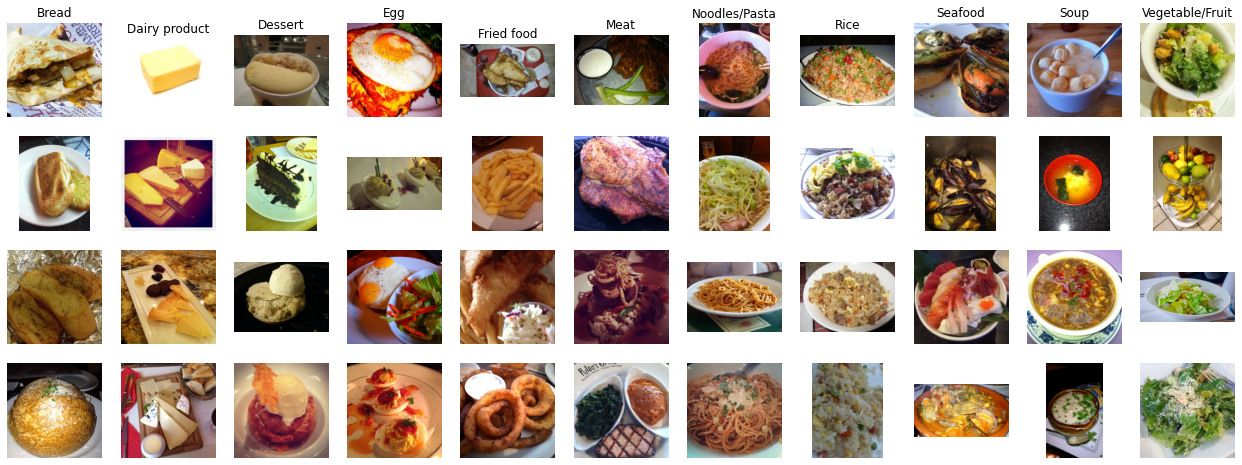

In [ ]:
num_classes = len(classes)
samples_per_class = 4
figure = plt.figure(figsize=(num_classes*2,samples_per_class*2))
for cls_idx, cls in enumerate(classes):
  idxs = np.flatnonzero(training_labels == cls_idx)
  idxs = np.random.choice(idxs, samples_per_class, replace=False)
  for i, idx in enumerate(idxs):
    plt_idx = i * num_classes + cls_idx + 1
    plt.subplot(samples_per_class, num_classes, plt_idx)
    im = Image.open(training_dir + training_images[idx])
    plt.imshow(im)
    plt.axis('off')
    if i == 0:
      plt.title(cls)
plt.show()

We can see that two dessert samples (for example) may look very different from one another - intra-class variability. Furthermore, samples from two different classes, such as a rice dish and a noodles dish, may look very similar to one another - inter-class similarity.

(In fact, some foods may really belong to multiple classes.  For example, fried chicken should really have both the "fried food" and "meat" labels, but only one class label is provided for each sample in the dataset.)

## Prepare data directories

Because the Food-11 dataset is very large, we won't want to load the entire dataset into memory at once.

Instead, Keras will let us read in images from disk as they are needed (in batches). For this to work, Keras [expects](https://keras.io/api/preprocessing/) that images will be organized in the following directory structure, with one subdirectory per class:

```
main_directory/
...class_a/
......a_image_1.jpg
......a_image_2.jpg
...class_b/
......b_image_1.jpg
......b_image_2.jpg
```

So, we will have to re-organize our directory structure to match.

In [ ]:
%cd /content/Food-11/training/

# loop over classes
for i in range(len(classes)):
  # make a directory for this class inside Food-11/training
  try:
    os.mkdir("class_%02d" % i)
  except FileExistsError:
    pass
  # get list of files inside Food-11/training that have this class label
  files = [f for f in os.listdir('/content/Food-11/training/') if f.startswith("%d_" % i)]
  # move each file to the subdirectory for the class
  for f in files:
    shutil.move(f, "class_%02d/" % i)

/content/Food-11/training


In [ ]:
%cd /content/Food-11/validation/

for i in range(len(classes)):
  try:
    os.mkdir("class_%02d" % i)
  except FileExistsError:
    pass
  files = [f for f in os.listdir('/content/Food-11/validation/') if f.startswith("%d_" % i)]
  for f in files:
    shutil.move(f, "class_%02d/" % i)

/content/Food-11/validation


In [ ]:
%cd /content/Food-11/evaluation/

for i in range(len(classes)):
  try:
    os.mkdir("class_%02d" % i)
  except FileExistsError:
    pass
  files = [f for f in os.listdir('/content/Food-11/evaluation/') if f.startswith("%d_" % i)]
  for f in files:
    shutil.move(f, "class_%02d/" % i)

/content/Food-11/evaluation


In [ ]:
# go back to default working directory
%cd /content

/content


Use the folder icon in Colab to look at your directory structure, and verify that within the training, validation, and evaluation data directories, there are subdirectories for each class containing the samples from that class.

## Prepare data generators

Now that we have prepared the directory structure, we can set up our data "flow".

In the next cell, I have defined a batch size and an image size. You are free to change these parameters. You can use any batch size that has good results in training, and you can change the input image size to match the input shape of whatever base model you are using.

In [ ]:
# TODO 1 (optional) - design choice on batch size, image shape
BATCH_SIZE = 8
INPUT_IMG_SIZE = 299 # for InceptionResnetV2

Then, I have defined some data generators to create augmented samples (slightly changed versions of the original samples). You are free to change any of the transformations used to generate the augmented data. You can learn more about the image transformations in the [ImageDataGenerator documentation](https://keras.io/api/preprocessing/image/#imagedatagenerator-class).

After we define the data generator, we use  `flow_from_directory` to get images off the disk during training, on an as-needed basis.

In [ ]:
# TODO 2 (optional) - design choices on image transformations for data augmentation

# prepare ImageDataGenerator to create augmented training samples
training_aug = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale=1.0/255,          # rescales so each pixel is in 0-1 range - keep this
	rotation_range=1,
	zoom_range=0.1,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.1,
	horizontal_flip=True,
	fill_mode="nearest")

# prepare generator that pulls images from directory (and resizes)
training_gen = training_aug.flow_from_directory(
	'/content/' + training_dir,
	target_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE),
	color_mode="rgb",
	shuffle=True,
	batch_size=BATCH_SIZE,
  class_mode='sparse')

Found 9866 images belonging to 11 classes.


Check the mapping of directory names to class labels:

In [ ]:
training_gen.class_indices

{'class_00': 0,
 'class_01': 1,
 'class_02': 2,
 'class_03': 3,
 'class_04': 4,
 'class_05': 5,
 'class_06': 6,
 'class_07': 7,
 'class_08': 8,
 'class_09': 9,
 'class_10': 10}

We can also set up the validation and evaluation (test) sets in a similar manner:

In [ ]:
validation_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255
)

validation_gen = validation_aug.flow_from_directory(
	'/content/' + validation_dir,
	target_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE),
	color_mode="rgb",
	shuffle=True,
	batch_size=BATCH_SIZE,
  class_mode='sparse')

Found 3430 images belonging to 11 classes.


In [ ]:
evaluation_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255
)

evaluation_gen = evaluation_aug.flow_from_directory(
	'/content/' + evaluation_dir,
	target_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE),
	color_mode="rgb",
	shuffle=False,
	batch_size=BATCH_SIZE,
  class_mode='sparse')

Found 3347 images belonging to 11 classes.


## Prepare base model

Now that the data is ready for us to train our model, we need to prepare the model.


First, review the models available as [Keras Applications](https://keras.io/api/applications/), and decide which model you will use. Make sure to click through from the table to the model documentation, to learn more about each model you are considering.

In the cell that follows, I have used the [VGG16](https://keras.io/api/applications/vgg/) model, but you can change it - you may use any model that you think will have good results.

In [ ]:
# TODO 3 (optional) - design choice on base model

# I tried InceptionResNetV2  ¯\_(ツ)_/¯
base_model = tf.keras.applications.InceptionResNetV2(
  input_shape=(INPUT_IMG_SIZE,INPUT_IMG_SIZE,3),
  include_top=False,
  pooling='avg'
)

219062272/219055592 [==============================] - 7s 0us/step


In [ ]:
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

## Train model with new classification head

In the following cell, "freeze" your base model (set it so that it is not trainable), and then construct a new model using the frozen base model with a new classification head.  (You can add a dropout layer in between if you think it will be helpful.)

(You can refer to this week's demo notebook for an example.)

In [ ]:
# TODO 4 (required) - prepare model with new classification head

base_model.trainable = False

model = tf.keras.models.Sequential()
# add to your model here...

model.add(base_model)
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(
    units=num_classes,
    activation=tf.keras.activations.softmax
))

Then, print a model summary:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 1536)              54336736  
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 11)                16907     
Total params: 54,353,643
Trainable params: 16,907
Non-trainable params: 54,336,736
_________________________________________________________________


(Make sure that most parameters are "non-trainable", because you have frozen the base model!)

Compile your model with an appropriate optimizer and loss function, and use accuracy as a metric.

In [ ]:
# TODO 5 (required) - design training parameters, and compile

# model.compile(...)

opt = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(
    optimizer=opt,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)]
)

Finally, fit your model with the new classification head for as many epochs as you think is appropriate. You may also use early stopping if you think it will be helpful.

Pass the validation data generator as `validation_data`.

In [ ]:
# TODO 6 (required) - fit model, you decide how many epochs
# note: you can get the number of training samples with training_gen.n
# and the number of validation samples with validation_gen.n

# n_epochs = ...
# hist = model.fit(...)


n_epochs = 10

hist = model.fit(
    training_gen,
    epochs=n_epochs,
    steps_per_epoch=training_gen.n//BATCH_SIZE,
    validation_data=validation_gen,
    validation_steps=validation_gen.n//BATCH_SIZE
)

Epoch 1/10
77/77 [==============================] - 425s 5s/step - loss: 1.2135 - accuracy: 0.6256 - val_loss: 0.7550 - val_accuracy: 0.7728
Epoch 2/10
77/77 [==============================] - 373s 5s/step - loss: 0.6902 - accuracy: 0.7838 - val_loss: 0.6284 - val_accuracy: 0.8053
Epoch 3/10
77/77 [==============================] - 369s 5s/step - loss: 0.5955 - accuracy: 0.8091 - val_loss: 0.5749 - val_accuracy: 0.8125
Epoch 4/10
77/77 [==============================] - 373s 5s/step - loss: 0.5532 - accuracy: 0.8202 - val_loss: 0.5626 - val_accuracy: 0.8176
Epoch 5/10
77/77 [==============================] - 371s 5s/step - loss: 0.5212 - accuracy: 0.8295 - val_loss: 0.5302 - val_accuracy: 0.8260
Epoch 6/10
77/77 [==============================] - 376s 5s/step - loss: 0.5065 - accuracy: 0.8301 - val_loss: 0.5136 - val_accuracy: 0.8260
Epoch 7/10
77/77 [==============================] - 380s 5s/step - loss: 0.4826 - accuracy: 0.8423 - val_loss: 0.4961 - val_accuracy: 0.8404
Epoch 8/10
77

In [ ]:
model.save(save_format='h5', filepath='/content/model-inception.h5')

Plot the training history. In one subplot, show loss vs. epoch for the training and validation sets on the same plot. In the second subplot, show accuracy vs. epoch for the training and validation sets on the same plot.

Make sure you show the training history from the *beginning* of training. (If you re-run the `hist = fit(...)` command, you'll overwrite the previous history and lose the training history from the beginning, so be careful not to do that in your final submission!)

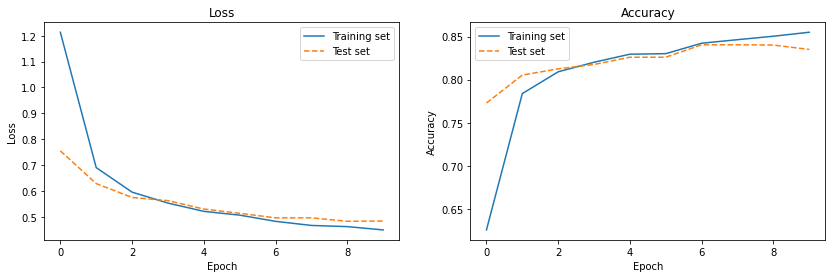

In [ ]:
# TODO 7 (required) - plot training history

loss = hist.history['loss']
val_loss = hist.history['val_loss']

accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Test set', linestyle='--')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(accuracy, label='Training set')
plt.plot(val_accuracy, label='Test set', linestyle='--')
plt.legend()

plt.show()

## Fine-tune model

Next, we are going to "un-freeze" the later layers of the model, and train it for a few more epochs on our data (with a smaller learning rate), so that it is better suited for our specific classification task.

Note that you should *not* create a new model. We're just going to continue training the model we already started training.

First, we will un-freeze the base model:

In [ ]:
base_model.trainable = True

Then, we will re-freeze only the first layers of the base model. In the cell below, I have left the last five layers, which includes the last set of convolutional filters, unfrozen. But you are free to change this number if you think you will get better performance.

In [ ]:
# TODO 8 (optional) - unfreeze some later layers. you decide how many

for layer in base_model.layers[:-19]:
	layer.trainable = False

The output of the following cell will indicate which layers in the base model are trainable, and which are not:

In [ ]:
for layer in base_model.layers:
  print("{}: {}".format(layer, layer.trainable))

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f3276871b10>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3275641e10>: False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f3275637e90>: False
<tensorflow.python.keras.layers.core.Activation object at 0x7f3272dee250>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3272d67a50>: False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f32730c9e90>: False
<tensorflow.python.keras.layers.core.Activation object at 0x7f3272d675d0>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f32730d2910>: False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f32730e1710>: False
<tensorflow.python.keras.layers.core.Activation object at 0x7f32730e72d0>: False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f32730e7a50>: False
<tensorflow.python.ker

Also, the model summary should now show more trainable parameters:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 1536)              54336736  
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 11)                16907     
Total params: 54,353,643
Trainable params: 4,719,307
Non-trainable params: 49,634,336
_________________________________________________________________


Re-compile your model, with a smaller learning rate.

In [ ]:
# TODO 9 (required) - re-compile model
# use a smaller learning rate for fine-tuning

# model.compile(...)

# use a smaller learning rate for fine-tuning
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer = opt,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

Fit your model (with some newly unfrozen layers) for some more epochs.

In [ ]:
# TODO 10 (required) - fit model, you decide how many epochs
# note: you can get the number of training samples with training_gen.n
# and the number of validation samples with validation_gen.n

# n_epochs_fine = ...
# hist_fine = model.fit(...)

n_epochs_fine = 10

hist_fine = model.fit(
    training_gen,
    epochs=n_epochs + n_epochs_fine,
    initial_epoch=n_epochs,
    steps_per_epoch=training_gen.n//BATCH_SIZE,
    validation_data=validation_gen,
    validation_steps=validation_gen.n//BATCH_SIZE
)

Epoch 11/20
77/77 [==============================] - 389s 5s/step - loss: 0.7778 - accuracy: 0.7354 - val_loss: 0.4783 - val_accuracy: 0.8465
Epoch 12/20
77/77 [==============================] - 373s 5s/step - loss: 0.5481 - accuracy: 0.8240 - val_loss: 0.4771 - val_accuracy: 0.8434
Epoch 13/20
77/77 [==============================] - 372s 5s/step - loss: 0.4809 - accuracy: 0.8426 - val_loss: 0.4652 - val_accuracy: 0.8498
Epoch 14/20
77/77 [==============================] - 372s 5s/step - loss: 0.4490 - accuracy: 0.8570 - val_loss: 0.4565 - val_accuracy: 0.8519
Epoch 15/20
77/77 [==============================] - 371s 5s/step - loss: 0.4220 - accuracy: 0.8667 - val_loss: 0.4454 - val_accuracy: 0.8552
Epoch 16/20
77/77 [==============================] - 371s 5s/step - loss: 0.4103 - accuracy: 0.8656 - val_loss: 0.4349 - val_accuracy: 0.8591
Epoch 17/20
77/77 [==============================] - 372s 5s/step - loss: 0.3972 - accuracy: 0.8697 - val_loss: 0.4275 - val_accuracy: 0.8624
Epoch 

In [ ]:
model.save(save_format='h5', filepath='/content/model-inception-finetuned.h5')

Plot the complete training history. In one subplot, show loss vs. epoch for the training and validation sets on the same plot. In the second subplot, show accuracy vs. epoch for the training and validation sets on the same plot. Draw a vertical line demarcating the first stage of training (training the classification head) and the second stage of training (fine tuning).

(You can refer to this week's demo notebook for an example.)

Make sure you show the training history from the *beginning* of training. (If you re-run the `hist_fine = fit(...)` command, you'll overwrite the previous history and lose the training history from the beginning, so be careful not to do that in your final submission!)

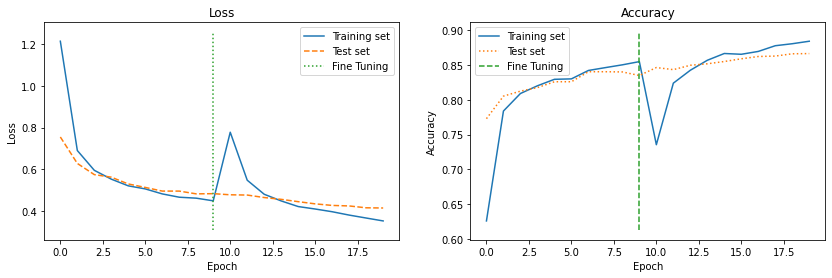

In [ ]:
# TODO 11 - required

loss = hist.history['loss'] + hist_fine.history['loss']
val_loss = hist.history['val_loss'] + hist_fine.history['val_loss']

accuracy = hist.history['accuracy'] + hist_fine.history['accuracy']
val_accuracy = hist.history['val_accuracy'] + hist_fine.history['val_accuracy']

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Validation set', linestyle='--')
plt.plot([n_epochs-1, n_epochs-1], plt.ylim(),label='Fine Tuning',linestyle='dotted')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(accuracy, label='Training set')
plt.plot(val_accuracy, label='Validation set', linestyle='dotted')
plt.plot([n_epochs-1, n_epochs-1], plt.ylim(), label='Fine Tuning', linestyle='--')
plt.legend()

plt.show()

Note that:

* It's normal to see a temporary drop in accuracy when you un-freeze later layers. After a few training epochs, your accuracy should start to increase again.
* It's also normal to see a big jump in accuracy when you un-freeze later layers. If your accuracy was previously limited because the model wasn't learning optimal features for your classification problem, un-freezing later layers is likely to help a lot.
* Alternatively, you may find that nothing dramatic happens when you un-freeze later layers.

## Evaluate model performance


Use `evaluate` to get the model performance - loss and accuracy - on the evaluation set. (You should not use the evaluation set at all prior to this step.)

In [ ]:
model.evaluate(evaluation_gen)

27/27 [==============================] - 75s 3s/step - loss: 0.3536 - accuracy: 0.8817


[0.3535785675048828, 0.8816850781440735]

We can also create a confusion matrix, to see which which classes are often confused with one another.

In [ ]:
y_pred_prob = model.predict(evaluation_gen)
y_pred = np.argmax(y_pred_prob, axis=1)

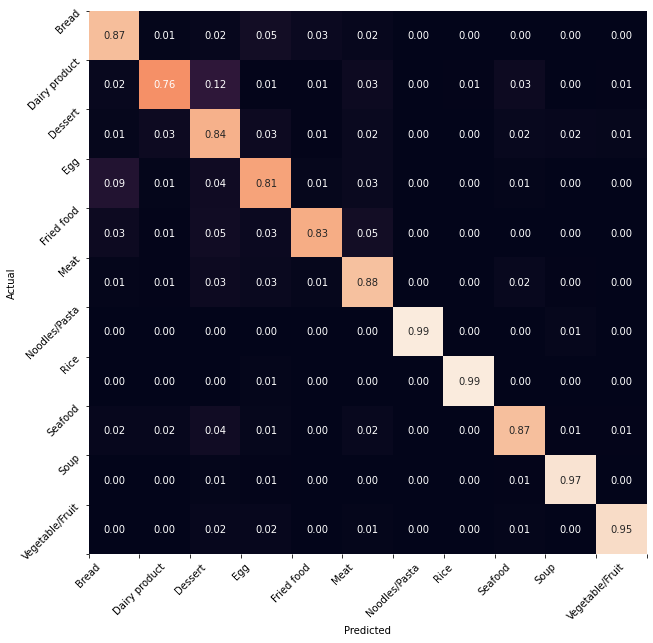

In [ ]:
cm = pd.crosstab(evaluation_gen.classes, y_pred,
                               rownames=['Actual'], colnames=['Predicted'],
                               normalize='index')
p = plt.figure(figsize=(10,10));
p = sns.heatmap(cm, annot=True, fmt=".2f", cbar=False);
p = plt.xticks(ticks=np.arange(0,11+1), labels=classes, rotation=45)
p = plt.yticks(ticks=np.arange(0,11+1), labels=classes, rotation=45)

## Use model on your own custom image

Take your own photograph of a food item in one of the 11 classes. Upload it to Colab, load it as a numpy array, and process the image (resize it, and scale so that each pixel takes on a value from 0 to 1).

Then, use the fitted model to get the per-class probabilities for each class.


Plot your image, and a bar plot showing the probability for the 5 most likely classes according to the model.

(You can refer to the "Classify with MobileNetV2" section of this week's notebook for an example.)

In [ ]:
# TODO 12 (required)

In [ ]:
!wget "https://www.chelseasmessyapron.com/wp-content/uploads/2018/01/15-Minute-Cheesy-Chicken-Tortilla-Soup2-500x500.jpg" --output-document=/content/test_image.jpeg

--2021-08-06 04:37:56--  https://www.chelseasmessyapron.com/wp-content/uploads/2018/01/15-Minute-Cheesy-Chicken-Tortilla-Soup2-500x500.jpg
Resolving www.chelseasmessyapron.com (www.chelseasmessyapron.com)... 104.26.6.229, 104.26.7.229, 172.67.71.156, ...
Connecting to www.chelseasmessyapron.com (www.chelseasmessyapron.com)|104.26.6.229|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54902 (54K) [image/jpeg]
Saving to: ‘/content/test_image.jpeg’

/content/test_image 100%[===================>]  53.62K  --.-KB/s    in 0.007s  

2021-08-06 04:37:57 (7.27 MB/s) - ‘/content/test_image.jpeg’ saved [54902/54902]



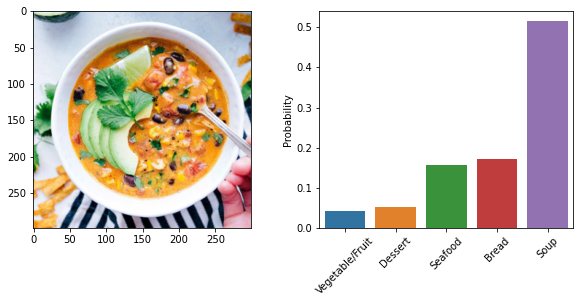

In [ ]:
im = Image.open('test_image.jpeg').convert('RGB')
image_resized = im.resize((INPUT_IMG_SIZE, INPUT_IMG_SIZE), Image.BICUBIC)
test_sample = np.array(image_resized)/255.0
test_sample = test_sample.reshape(1, INPUT_IMG_SIZE, INPUT_IMG_SIZE, 3)

test_probs = model.predict(test_sample)

most_likely_classes = np.argsort(test_probs.squeeze())[-5:]

plt.figure(figsize=(10,4));

plt.subplot(1,2,1)
plt.imshow(test_sample.reshape(INPUT_IMG_SIZE, INPUT_IMG_SIZE, 3));

plt.subplot(1,2,2)
p = sns.barplot(x=classes[most_likely_classes], y=test_probs.squeeze()[most_likely_classes]);
plt.ylabel("Probability");
p.set_xticklabels(p.get_xticklabels(), rotation=45);


In [ ]:
!wget "https://cdn11.bigcommerce.com/s-q83qdckkjh/images/stencil/1280x1280/products/355/3111/Par-CelBC__72675.1521911670.jpg" --output-document=/content/test_image.jpeg

--2021-08-06 04:38:02--  https://cdn11.bigcommerce.com/s-q83qdckkjh/images/stencil/1280x1280/products/355/3111/Par-CelBC__72675.1521911670.jpg
Resolving cdn11.bigcommerce.com (cdn11.bigcommerce.com)... 63.141.128.3, 192.200.160.253
Connecting to cdn11.bigcommerce.com (cdn11.bigcommerce.com)|63.141.128.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘/content/test_image.jpeg’

/content/test_image     [ <=>                ] 150.98K  --.-KB/s    in 0.01s   

2021-08-06 04:38:03 (10.6 MB/s) - ‘/content/test_image.jpeg’ saved [154601]



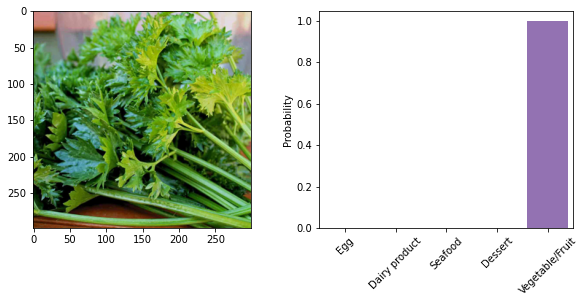

In [ ]:
im = Image.open('test_image.jpeg').convert('RGB')
image_resized = im.resize((INPUT_IMG_SIZE, INPUT_IMG_SIZE), Image.BICUBIC)
test_sample = np.array(image_resized)/255.0
test_sample = test_sample.reshape(1, INPUT_IMG_SIZE, INPUT_IMG_SIZE, 3)

test_probs = model.predict(test_sample)

most_likely_classes = np.argsort(test_probs.squeeze())[-5:]

plt.figure(figsize=(10,4));

plt.subplot(1,2,1)
plt.imshow(test_sample.reshape(INPUT_IMG_SIZE, INPUT_IMG_SIZE, 3));

plt.subplot(1,2,2)
p = sns.barplot(x=classes[most_likely_classes], y=test_probs.squeeze()[most_likely_classes]);
plt.ylabel("Probability");
p.set_xticklabels(p.get_xticklabels(), rotation=45);
